In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import cv2
import random
# import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import seaborn as sns
from collections import Counter
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import callbacks
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import RMSprop
# from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, CSVLogger

from time import time
from datetime import datetime

In [2]:
# DATADIR = r'/Users/zahidulislam/Documents/Research/rmfrd/'
DATA_DIR = r'C:\Users\HP\Documents\Zahid\Masked Face\rmfrd\rmfrd'

TRAIN_DATADIR = os.path.join(DATA_DIR, "AFDB_face_dataset")
TEST_DATADIR = os.path.join(DATA_DIR, "AFDB_masked_face_dataset")


TEST_CATEGORIES = []
for folder in sorted(os.listdir(TEST_DATADIR)):
    if folder == ".DS_Store":
        continue
    TEST_CATEGORIES.append(folder)

print(len(TEST_CATEGORIES))

377


In [3]:

TRAIN_CATEGORIES = []
for folder in sorted(os.listdir(TRAIN_DATADIR)):
    if folder == ".DS_Store":
        continue
    TRAIN_CATEGORIES.append(folder)

print(len(TRAIN_CATEGORIES))

460


# Image Size

In [4]:

IMG_SIZE = 64

In [5]:
error_folder = []
for folder in TRAIN_CATEGORIES:
    if folder not in TEST_CATEGORIES:
        error_folder.append(folder)
        

In [6]:
error_folder = []
for folder in TEST_CATEGORIES:
    if folder not in TRAIN_CATEGORIES:
        error_folder.append(folder)

In [7]:
CATEGORIES = TEST_CATEGORIES

##  Training and testing data generator

In [8]:
training_data = []
testing_data = []
# flatten_training_data = []
# target_array = []

def create_training_data():
  for catagory in CATEGORIES:
    if catagory[0] == '.':
        continue

    train_path = os.path.join(TRAIN_DATADIR,catagory)
    test_path = os.path.join(TEST_DATADIR,catagory)
    class_num = CATEGORIES.index(catagory)
    
    for img in os.listdir(train_path):
        
        if img[0] == '.' :
            continue
#         print(img)
#         print(catagory, img)
        img_array = cv2.imread(os.path.join(train_path, img))
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        
        training_data.append([new_array, class_num])

    for img in os.listdir(test_path):
        
        if img[0] == '.' :
            continue
#         print(img)
#         print(catagory, img)
        img_array = cv2.imread(os.path.join(test_path, img))
#         print(os.path.join(test_path, img))
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        
        testing_data.append([new_array, class_num])



            

            
     
             
            

t0 = time()
create_training_data()
print(f'Taken Time {time()-t0}')

# beep()

Taken Time 78.0159523487091


In [9]:
# data_prep()
# def data_prep():
X_train = []
Y_train = []
for features, label in training_data:
  X_train.append(features)
  Y_train.append(label)

X_train = np.array(X_train).reshape(-1, IMG_SIZE, IMG_SIZE,3)

###################

X_test = []
Y_test = []
for features, label in testing_data:
  X_test.append(features)
  Y_test.append(label)

X_test = np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE,3)

################


Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

X_train = X_train/255.0
X_test = X_test/255.0

print(f'X_train.shape --> {X_train.shape}')
print(f'X_test.shape --> {X_test.shape}')
print(f'Y_train.shape --> {Y_train.shape}')
print(f'Y_test.shape --> {Y_test.shape}')

X_train.shape --> (75830, 64, 64, 3)
X_test.shape --> (1398, 64, 64, 3)
Y_train.shape --> (75830,)
Y_test.shape --> (1398,)


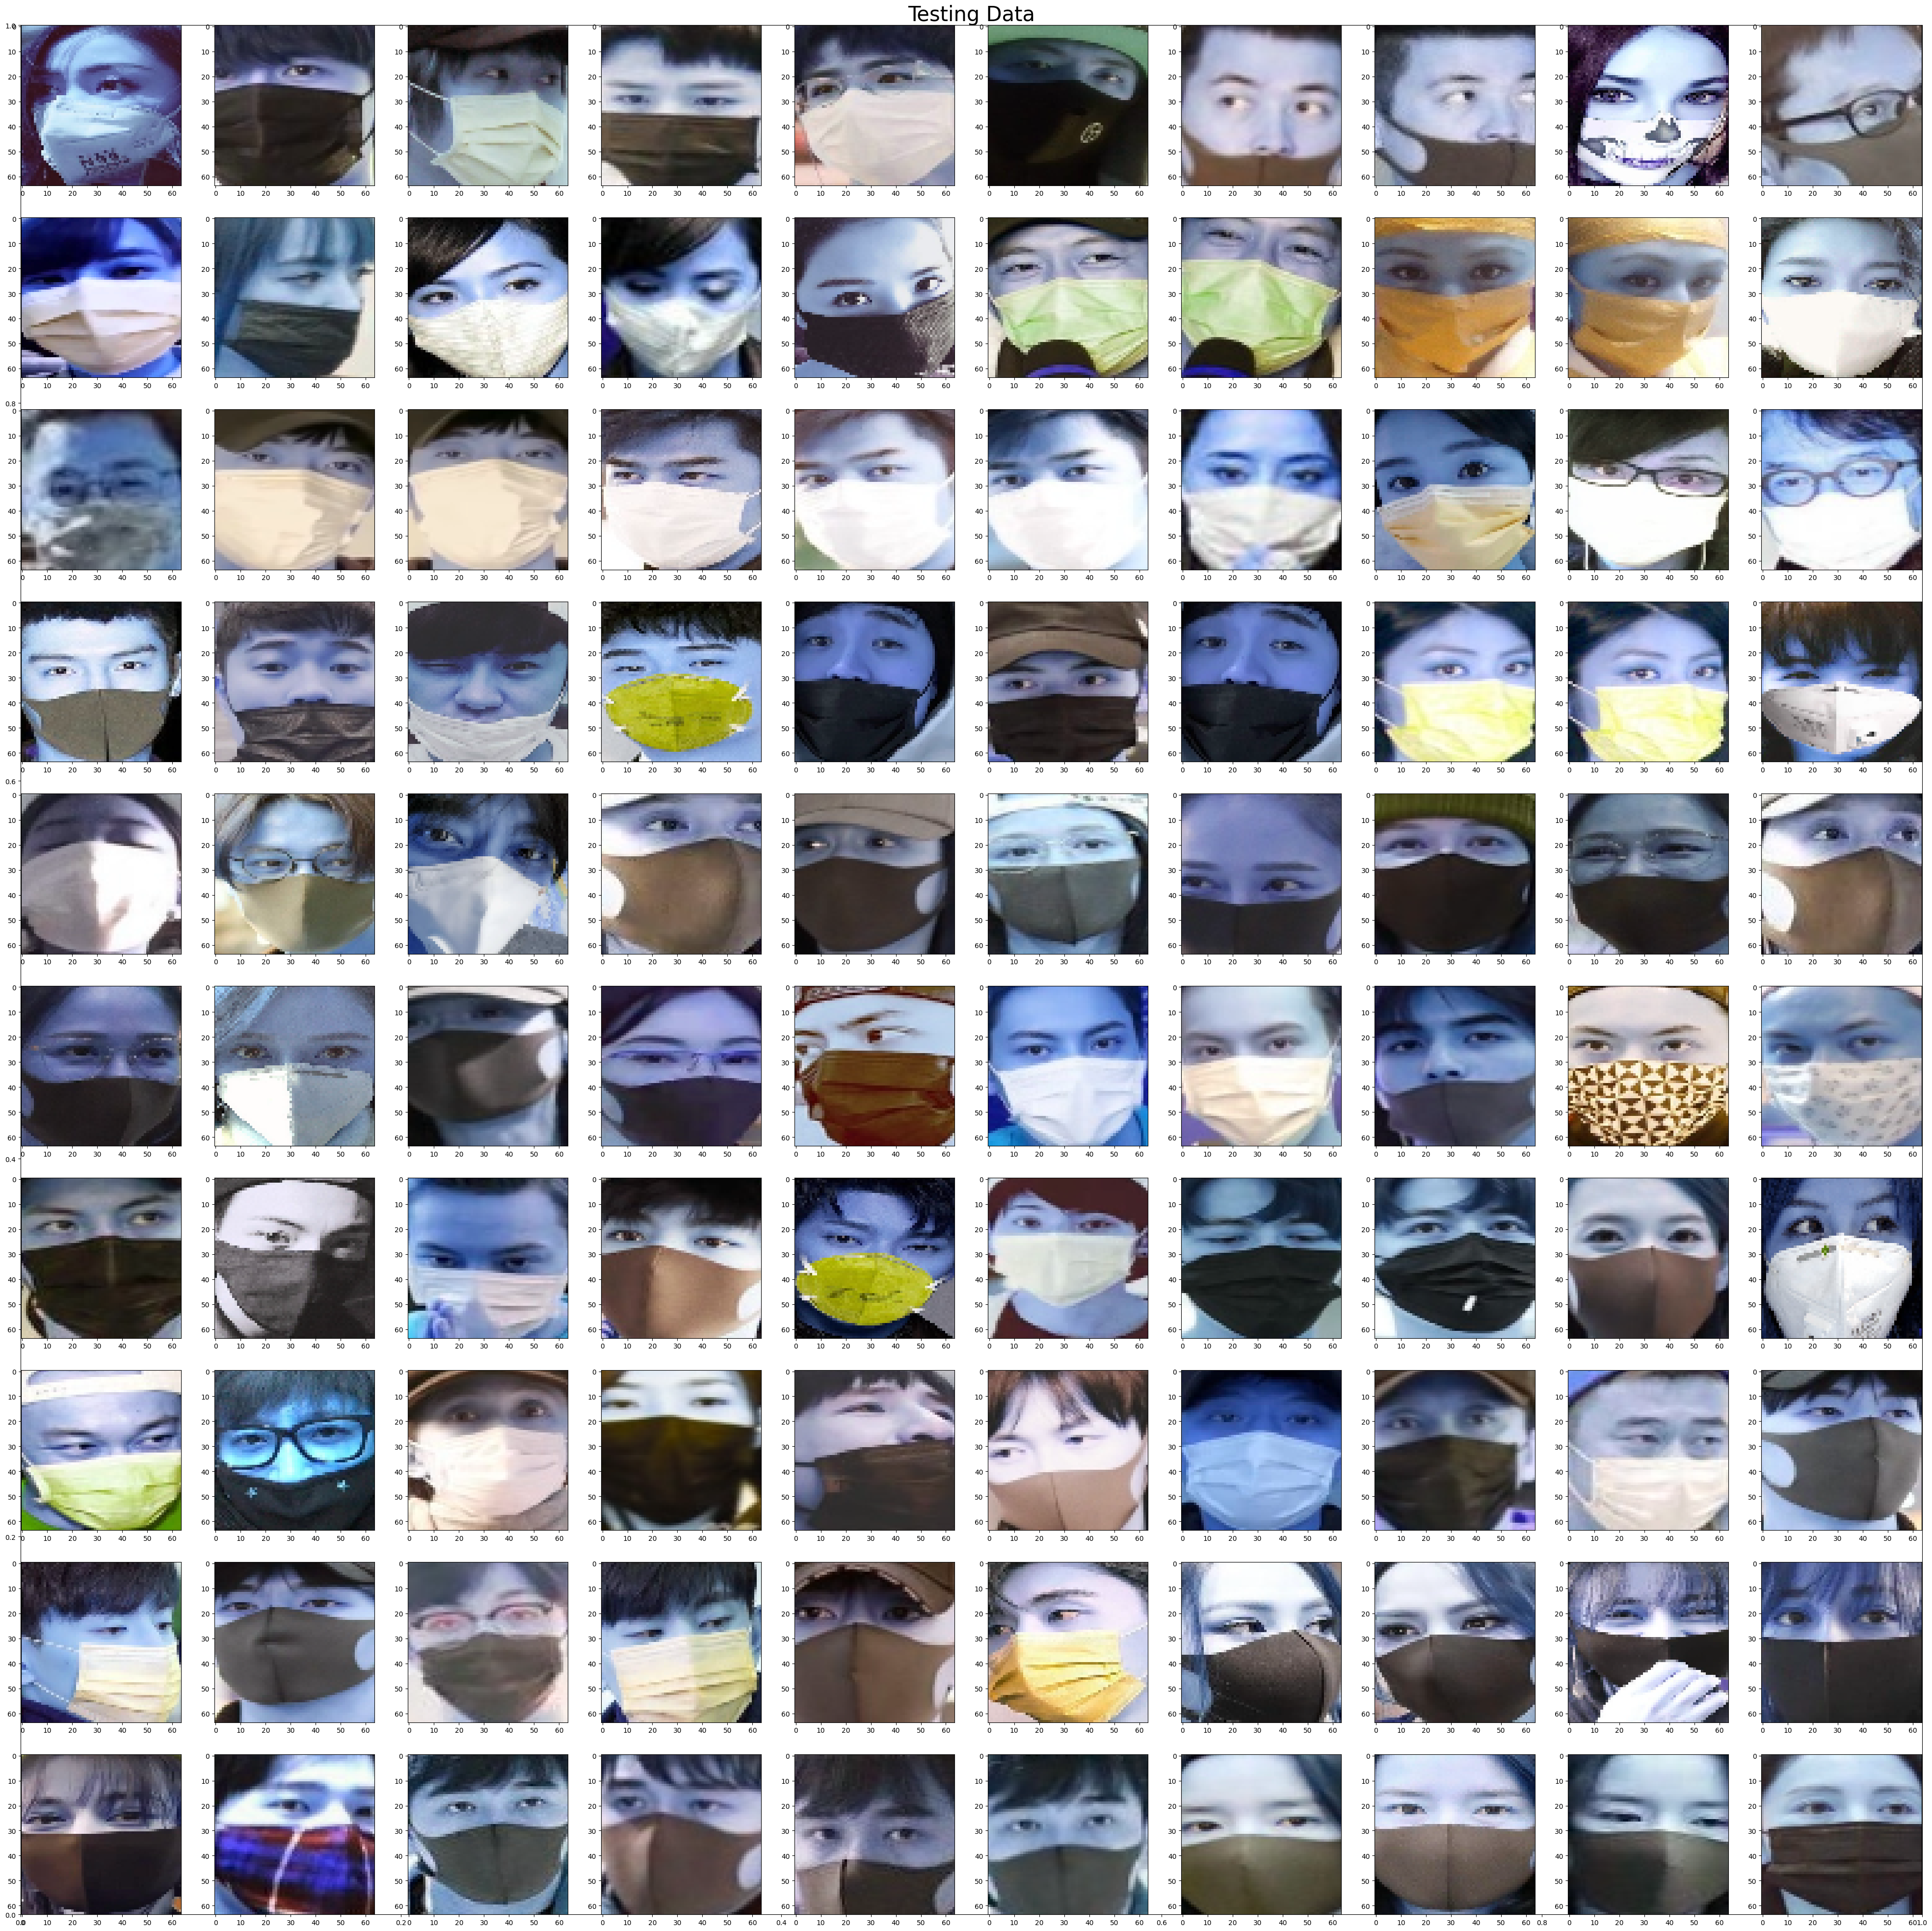

In [10]:
# for image in testing_data[:10][0]:
fig = plt.figure(figsize = (50,50))
rows = 10
cols = 10
plt.title("Testing Data", fontsize= 30)
for j in range(0, rows*cols):
    fig.add_subplot(rows, cols, j+1)
    plt.imshow(testing_data[j][0])

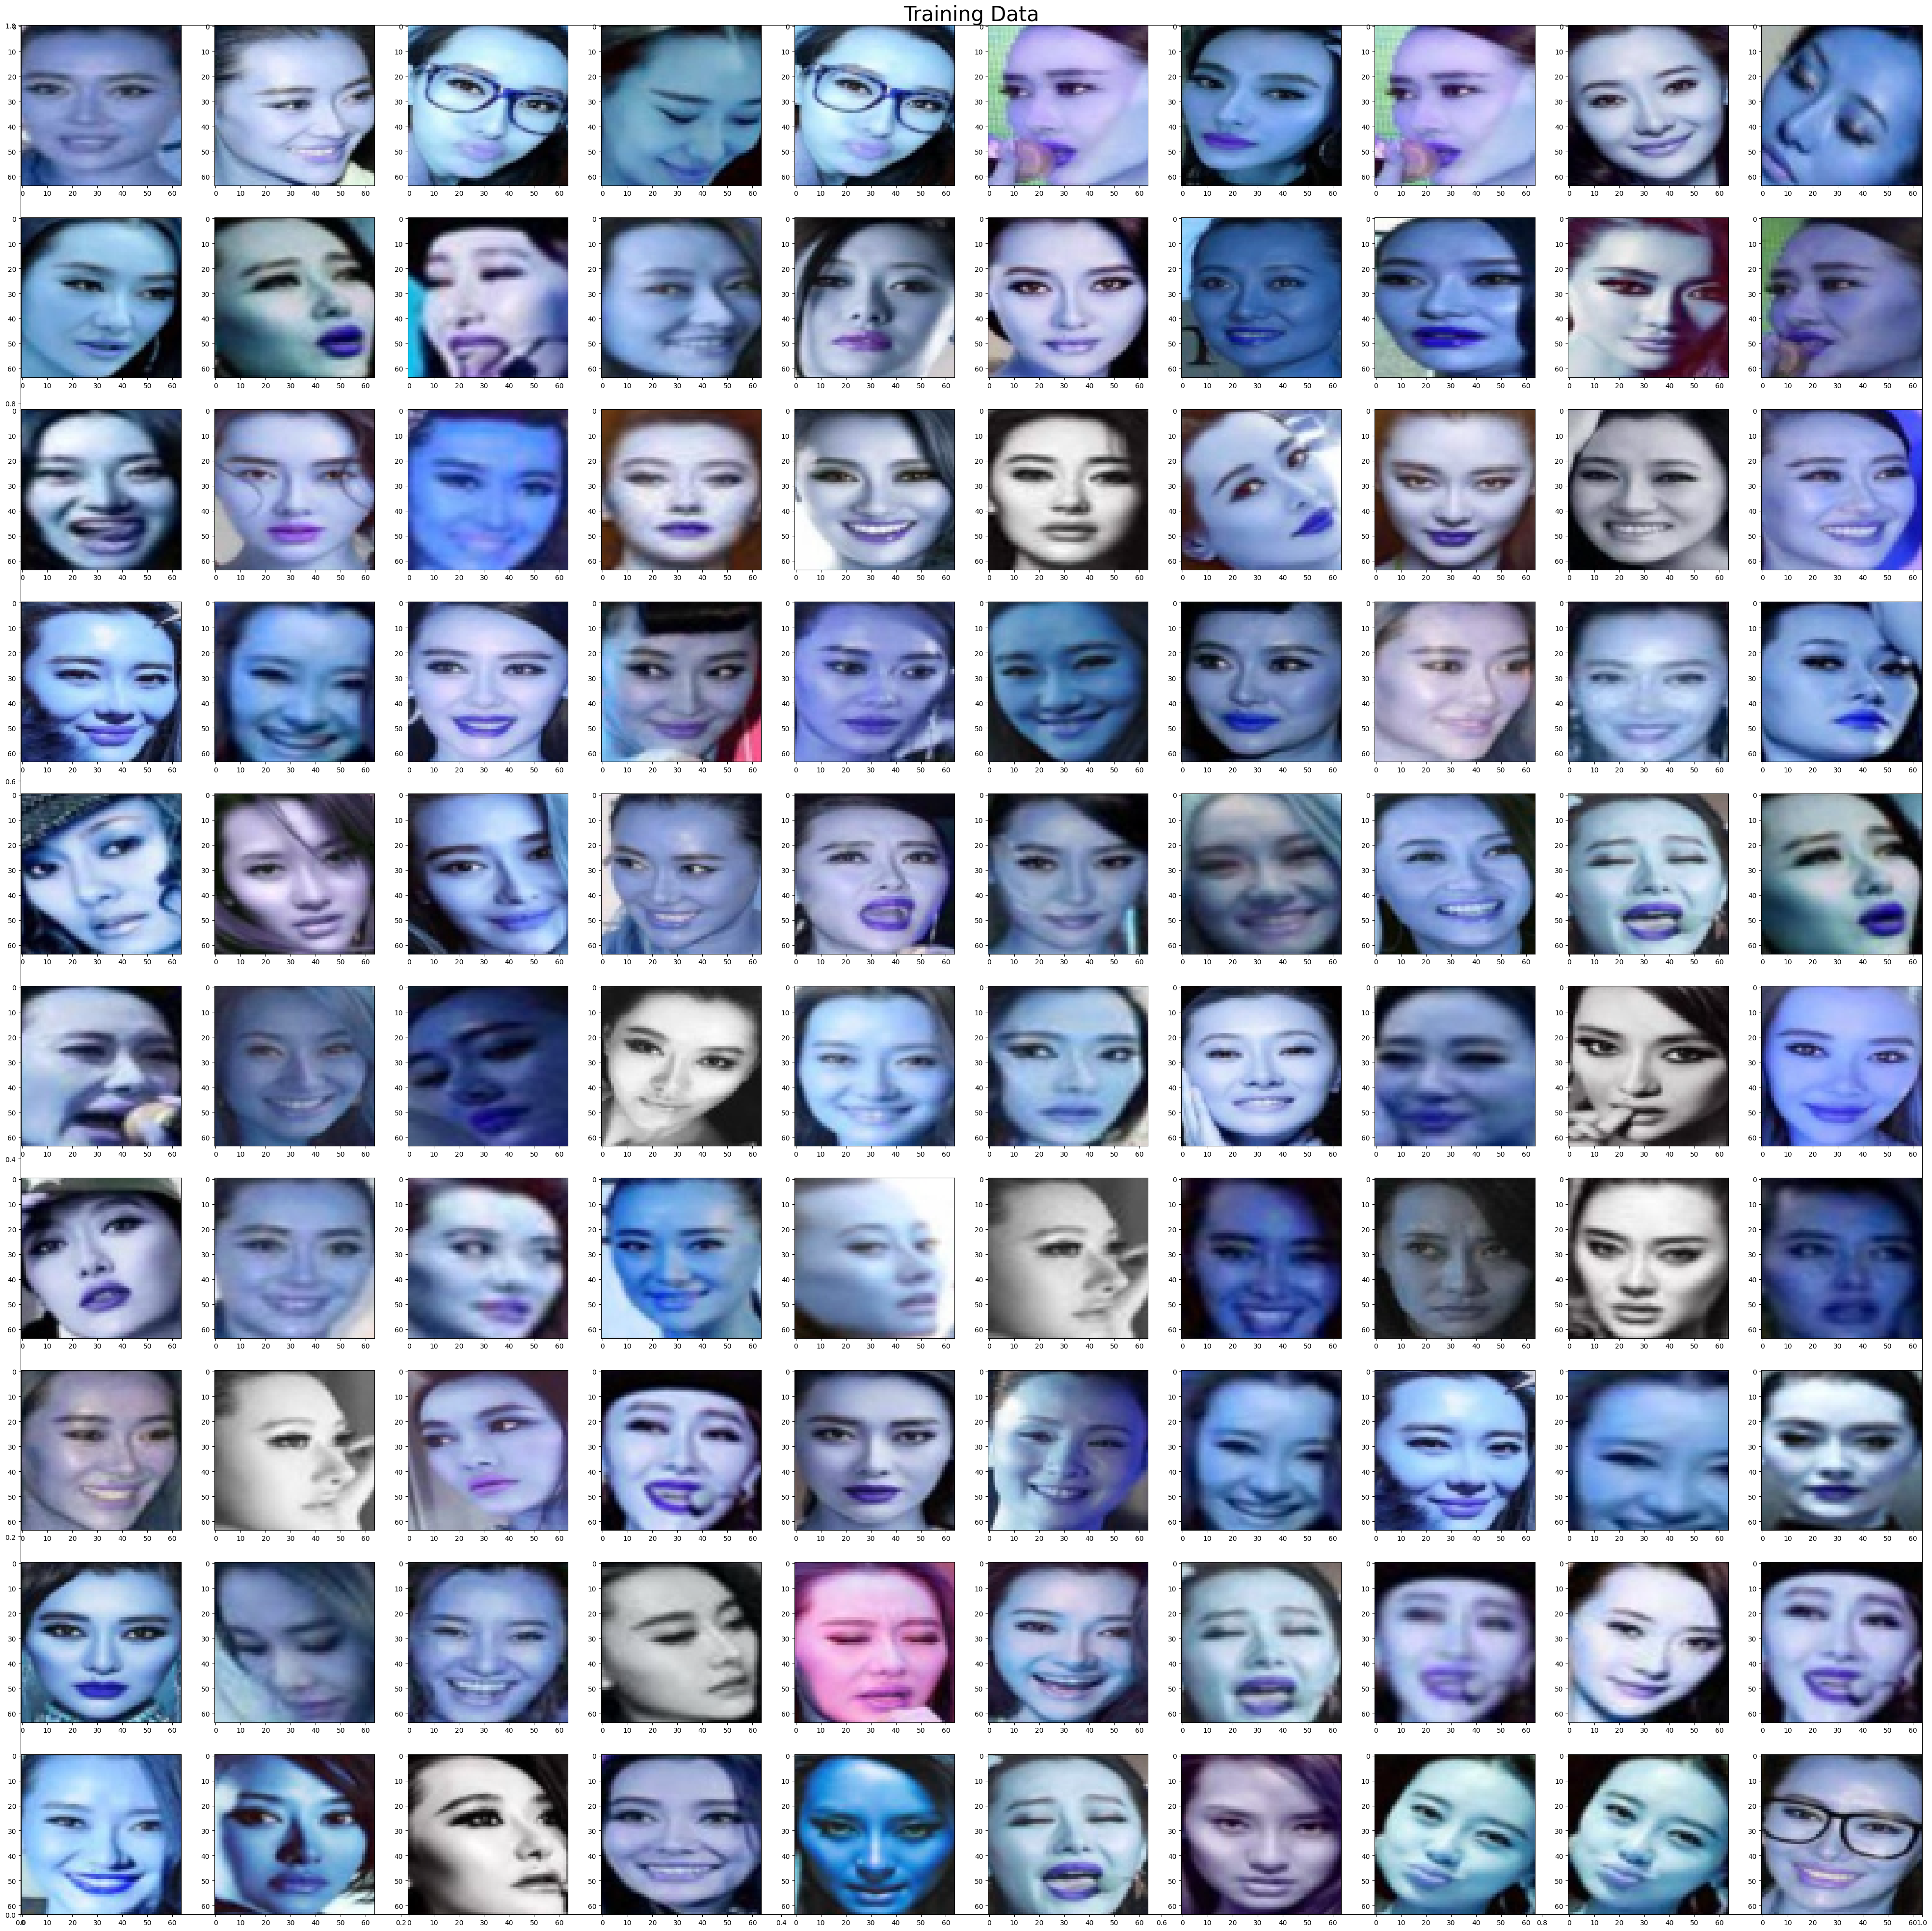

In [11]:
# for image in testing_data[:10][0]:
fig = plt.figure(figsize = (50,50))
rows = 10
cols = 10
plt.title("Training Data", fontsize= 30)
for j in range(0, rows*cols):
    fig.add_subplot(rows, cols, j+1)
    plt.imshow(training_data[j][0])

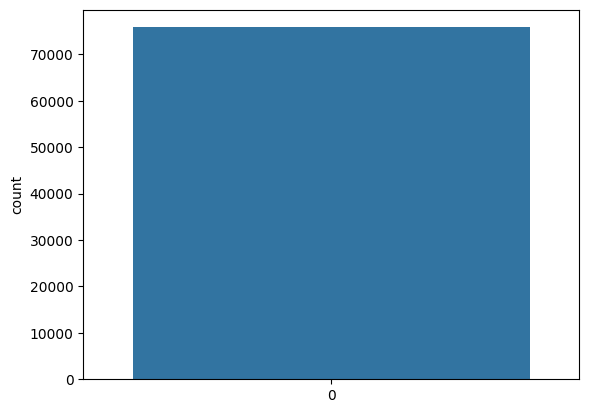

In [12]:
g = sns.countplot(Y_train)

In [13]:
print(f'X_train.shape --> {X_train.shape}')
print(f'X_test.shape --> {X_test.shape}')
print(f'Y_train.shape --> {Y_train.shape}')
print(f'Y_test.shape --> {Y_test.shape}')


X_train.shape --> (75830, 64, 64, 3)
X_test.shape --> (1398, 64, 64, 3)
Y_train.shape --> (75830,)
Y_test.shape --> (1398,)


In [14]:
earlystopping = callbacks.EarlyStopping(monitor ="val_accuracy", 
                                        mode ="max", patience = 5, 
                                        restore_best_weights = True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)



In [15]:
def get_date_time():
    a = datetime.now()
    date_time_now = a.strftime("%d_%b__%H_%M") 
    return date_time_now

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


def get_results(model):
    
    results = {
#     "train_loss":0,
    "test_loss":0,
#     "train_acc":0,
    "test_acc":0,
    "recall":0,
    "precision":0,
    "f1":0,
    
    }
    
    y_pred = model.predict(X_test)
    y_pred_bool = []

    for y in y_pred:
      y_pred_bool.append(np.argmax(y))
    
#     y_pred_bool = np.array(y_pred_bool)
#     print(type(Y_test), type(y_pred_bool))
#     print(Y_test, y_pred_bool)
    
    results["test_loss"], results["test_acc"]= model.evaluate(X_test, Y_test, verbose = 0) 
    
    results["precision"] = precision_score(Y_test, y_pred_bool, average = 'weighted')
    results["recall"] = recall_score (Y_test, y_pred_bool, average = 'weighted')
    results["f1"] = f1_score(Y_test, y_pred_bool, average = 'weighted')
    
    return results



In [17]:
def get_name(model, t, acc = False):
    
    root_path = r"C:\Users\HP\Documents\Zahid\Masked Face"
    
    model_save_path =os.path.join(root_path, "Model")
    log_save_path = os.path.join(root_path, "Logs")
    graph_save_path = os.path.join(root_path, "Graphs")
    results_save_path = os.path.join(root_path, "Results")
    
    
    if t=="graph":
        if acc:
            uni_name = os.path.join(graph_save_path, f"{model} RMFRD ACC {get_date_time()}.jpg")
        else:
            uni_name = os.path.join(graph_save_path, f"{model} RMFRD Face Loss {get_date_time()}.jpg")
            
    elif t=="model":
        uni_name = os.path.join(model_save_path, f"{model} RMFRD Face {get_date_time()}.h5")
    elif t=='log':
        uni_name = os.path.join(log_save_path, f"{model} RMFRD Face {get_date_time()}.log")
    elif t== 'results':
        uni_name = os.path.join(results_save_path, f"{model} RMFRD Face {get_date_time()}.csv")
    else:
        raise ValueError(f'You entered invalid value')
        
        
    return uni_name
    
    

In [18]:
get_name("cnn", "graph",)

'C:\\Users\\HP\\Documents\\Zahid\\Masked Face\\Graphs\\cnn RMFRD Face Loss 23_Feb__14_48.jpg'

# CNN

In [19]:

cnn_model = Sequential()



cnn_model.add(Conv2D(64, (3,3), activation = 'relu', input_shape = X_train.shape[1:]))
cnn_model.add(MaxPool2D(pool_size=(2,2)))

cnn_model.add(Conv2D(128, (3,3), activation = 'relu'))
# model.add(Dropout(.50))
cnn_model.add(MaxPool2D(pool_size=(2,2)))

cnn_model.add(Conv2D(256, (3,3), activation = 'relu'))
# model.add(Dropout(.50))
cnn_model.add(MaxPool2D(pool_size=(2,2)))

cnn_model.add(Conv2D(512, (3,3), activation = 'relu'))
# model.add(Dropout(.50))
cnn_model.add(MaxPool2D(pool_size=(2,2)))

cnn_model.add(Flatten())
cnn_model.add(Dense(4096, activation = 'relu'))
cnn_model.add(Dropout(.50))


cnn_model.add(Dense(len(CATEGORIES), activation = 'softmax'))



cnn_model.compile(loss = "SparseCategoricalCrossentropy", optimizer = "adam", metrics = ['accuracy'])
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 512)         1

In [20]:
X_train.size * X_train.itemsize 

7454392320

In [ ]:
batch_size = 8
name = get_name("CNN", "log")

csv_logger = CSVLogger(name)

history = cnn_model.fit(X_train,Y_train, batch_size=batch_size, epochs = 10, 
                              validation_data = (X_test,Y_test),
                              verbose = 2, 
                              
                              callbacks =[learning_rate_reduction,
                                          csv_logger
                                         ]
                              )
beep()

Epoch 1/10
9479/9479 - 83s - loss: 5.8943 - accuracy: 0.0039 - val_loss: 5.9727 - val_accuracy: 0.0064
Epoch 2/10
9479/9479 - 78s - loss: 5.8883 - accuracy: 0.0042 - val_loss: 5.9715 - val_accuracy: 7.1531e-04
Epoch 3/10


### CNN result save

In [ ]:

cnn_results = get_results(cnn_model)
cnn_results

### CNN Model save

In [ ]:
name = get_name("CNN", "model")
cnn_model.save(name)

### CNN Graph save

In [ ]:

plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], color='teal', label="Training loss", marker='o')
plt.plot(history.history['val_loss'], color='red', label="validation loss", marker='o')

legend = plt.legend(loc='best', shadow=True, fontsize=12)

plt.xlabel('Epochs',fontsize=12, color = 'black')
plt.ylabel('Loss', fontsize=12, color = 'black')

plt.title("Training Vs Validation Loss Using CNN",fontsize=12, color = 'black' )
plt.grid()

name = get_name("CNN", "graph")
plt.savefig(name, dpi = 300)

In [ ]:

plt.figure(figsize=(10,8))
plt.plot(history.history['accuracy'], color='teal', label="Training Accuracy", marker='o')
plt.plot(history.history['val_accuracy'], color='red', label="Validation Accuracy", marker='o')
legend = plt.legend(loc='best', shadow=True,fontsize=12)
plt.xlabel('Epochs',fontsize=12, color = 'black')
plt.ylabel('Accuracy',fontsize=12, color = 'black')
plt.title("Training Vs Validation Accuracy Using CNN" ,fontsize=12, color = 'black')
plt.grid()

name = get_name("CNN", "graph", acc = True)
plt.savefig(name, dpi = 300)

In [ ]:
# fig, ax = plt.subplots(2,1)
# ax[0].plot(history.history['loss'], color='b', label="Training loss")
# ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
# legend = ax[0].legend(loc='best', shadow=True)

# ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
# ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
# legend = ax[1].legend(loc='best', shadow=True)

# Transfer Learning

## VGG19 Pure

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19

import tensorflow

In [ ]:
vgg19 = VGG19(input_shape = X_train.shape[1:], weights = 'imagenet', include_top = False)

In [ ]:
for layer in vgg19.layers:
    layer.trainable = False
    

num_classes = len(CATEGORIES)

x = Flatten()(vgg19.output)

predictions = Dense(num_classes, activation = 'softmax')(x)


vgg19_model = Model(inputs = vgg19.input, outputs = predictions)


vgg19_model.compile(optimizer='adam', loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

In [ ]:
uni_name = f"VGG19 Open Face {get_date_time()}"

In [ ]:
name =get_name("VGG19", "log")
csv_logger = CSVLogger(name)
history = vgg19_model.fit(X_train,Y_train, batch_size=128, epochs = 50, 
                              validation_data = (X_test,Y_test),
                              verbose = 2, 
                              callbacks =[learning_rate_reduction,
                                          csv_logger
                                         ]
                              )
beep()

In [ ]:
name =get_name("VGG19", "model")
vgg19_model.save(name)

In [ ]:

vgg19_results = get_results(vgg19_model)
vgg19_results

In [ ]:

plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], color='teal', label="Training loss", marker='o')
plt.plot(history.history['val_loss'], color='red', label="validation loss", marker='o')
legend = plt.legend(loc='best', shadow=True, fontsize=12)
plt.xlabel('Epochs',fontsize=12, color = 'black')
plt.ylabel('Loss', fontsize=12, color = 'black')
plt.title("Training Vs Validation Loss Using VGG19",fontsize=12, color = 'black' )
plt.grid()


name = get_name("VGG19", "graph")
plt.savefig(name, dpi = 300)

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(history.history['accuracy'], color='teal', label="Training Accuracy", marker='o')
plt.plot(history.history['val_accuracy'], color='red', label="Validation Accuracy", marker='o')
legend = plt.legend(loc='best', shadow=True,fontsize=12)
plt.xlabel('Epochs',fontsize=12, color = 'black')
plt.ylabel('Accuracy',fontsize=12, color = 'black')
plt.title("Training Vs Validation Accuracy Using VGG19" ,fontsize=12, color = 'black')
plt.grid()


name = get_name("VGG19", "graph", acc = True)
plt.savefig(name, dpi = 300)

In [ ]:
# vgg19_model.save("vgg19_customized_96.h5")

## VGG19 Modified

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model

In [ ]:
ex_vgg19 = VGG19(input_shape = X_train.shape[1:], weights = 'imagenet', include_top = False)

In [ ]:
for layer in ex_vgg19.layers:
    layer.trainable = False
    

num_classes = len(CATEGORIES)

x = Flatten()(ex_vgg19.output)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
predictions = Dense(num_classes, activation = 'softmax')(x)


ex_vgg19_model = Model(inputs = ex_vgg19.input, outputs = predictions)


ex_vgg19_model.compile(optimizer='adam', loss='SparseCategoricalCrossentropy', metrics=['accuracy'])




# vgg19_model = Model(inputs = vgg19.input, outputs = prediction)

In [ ]:
# vgg19_model.summary()


In [ ]:
name = get_name("EX_VGG19", "log")
csv_logger = CSVLogger(name)
history = ex_vgg19_model.fit(X_train,Y_train, batch_size=128, epochs = 50, 
                              validation_data = (X_test,Y_test),
                              verbose = 2, 
                              
                              callbacks =[learning_rate_reduction,  csv_logger]
                              )
beep()

In [ ]:
name = get_name("EX_VGG19", "model")
ex_vgg19_model.save(name)

In [ ]:

plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], color='teal', label="Training loss", marker='o')
plt.plot(history.history['val_loss'], color='red', label="validation loss", marker='o')
legend = plt.legend(loc='best', shadow=True, fontsize=12)
plt.xlabel('Epochs',fontsize=12, color = 'black')
plt.ylabel('Loss', fontsize=12, color = 'black')
plt.title("Training Vs Validation Loss Using Extended VGG19",fontsize=12, color = 'black' )
plt.grid()


name = get_name("EX_VGG19", "graph")
plt.savefig(name, dpi = 300)

In [ ]:

plt.figure(figsize=(10,8))
plt.plot(history.history['accuracy'], color='teal', label="Training Accuracy", marker='o')
plt.plot(history.history['val_accuracy'], color='red', label="Validation Accuracy", marker='o')
legend = plt.legend(loc='best', shadow=True,fontsize=12)
plt.xlabel('Epochs',fontsize=12, color = 'black')
plt.ylabel('Accuracy',fontsize=12, color = 'black')
plt.title("Training Vs Validation Accuracy Using Extended Vgg19",fontsize=12, color = 'black')
plt.grid()


name = get_name("EX_VGG19", "graph", acc = True)
plt.savefig(name, dpi = 300)

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:

Ex_vgg19_results = get_results(ex_vgg19_model)
Ex_vgg19_results

## Resnet

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
resnet50 = ResNet50(input_shape = X_train.shape[1:], weights = 'imagenet', include_top = False)


for layer in resnet50.layers:
    layer.trainable = False

x = Flatten()(resnet50.output)
prediction = Dense(len(CATEGORIES), activation = 'softmax')(x)
resnet50_model = Model(inputs = resnet50.input, outputs = prediction)

In [ ]:
resnet50_model.summary()


In [ ]:
resnet50_model.compile(loss = "SparseCategoricalCrossentropy", optimizer = "adam", metrics = ['accuracy'])

In [ ]:
history = resnet50_model.fit(X_train,Y_train, batch_size=128, epochs = 50, 
                              validation_data = (X_test,Y_test),
                              verbose = 2, 
                              
#                               callbacks =[learning_rate_reduction, earlystopping]
                              )

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:

plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], color='teal', label="Training loss", marker='o')
plt.plot(history.history['val_loss'], color='red', label="validation loss", marker='o')
legend = plt.legend(loc='best', shadow=True, fontsize=12)
plt.xlabel('Epochs',fontsize=12, color = 'black')
plt.ylabel('Loss', fontsize=12, color = 'black')
plt.title("Training Vs Validation Loss Using Resnet50",fontsize=12, color = 'black' )
plt.grid()


name = get_name("resnet50", "graph")
plt.savefig(name, dpi = 300)

In [ ]:

plt.figure(figsize=(10,8))
plt.plot(history.history['accuracy'], color='teal', label="Training Accuracy", marker='o')
plt.plot(history.history['val_accuracy'], color='red', label="Validation Accuracy", marker='o')
legend = plt.legend(loc='best', shadow=True,fontsize=12)
plt.xlabel('Epochs',fontsize=12, color = 'black')
plt.ylabel('Accuracy',fontsize=12, color = 'black')
plt.title("Training Vs Validation Accuracy Using Resnet50",fontsize=12, color = 'black')
plt.grid()


name = get_name("resnet50", "graph", acc = True)
plt.savefig(name, dpi = 300)

In [ ]:
name = get_name("resnet50", "model")
resnet50_model.save(name)

In [ ]:
resnet_results = get_results(resnet50_model)
resnet_results

## Inception V3

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
inceptionv3 = InceptionV3(input_shape = X_train.shape[1:], weights = 'imagenet', include_top = False)

In [ ]:
for layer in inceptionv3.layers:
    layer.trainable = False

x = Flatten()(inceptionv3.output)
prediction = Dense(len(CATEGORIES), activation = 'softmax')(x)
inceptionv3_model = Model(inputs = inceptionv3.input, outputs = prediction)

In [ ]:
inceptionv3_model.summary()

In [ ]:
inceptionv3_model.compile(loss = "SparseCategoricalCrossentropy", optimizer = "adam", metrics = ['accuracy'])

In [ ]:
history = inceptionv3_model.fit(X_train,Y_train, batch_size=128, epochs = 50, 
                              validation_data = (X_test,Y_test),
                              verbose = 2, 
                              
#                               callbacks =[learning_rate_reduction, earlystopping]
                              )

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
inceptionv3_results = get_results(inceptionv3_model)
inceptionv3_results

## MobileNet

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet
mobilenet = MobileNet(input_shape = X_train.shape[1:], weights = 'imagenet', include_top = False)

In [ ]:
for layer in mobilenet.layers:
    layer.trainable = False

x = Flatten()(mobilenet.output)
prediction = Dense(len(CATEGORIES), activation = 'softmax')(x)
mobilenet_model = Model(inputs = mobilenet.input, outputs = prediction)

In [ ]:
mobilenet_model.summary()

In [ ]:
mobilenet_model.compile(loss = "SparseCategoricalCrossentropy", optimizer = "adam", metrics = ['accuracy'])

In [ ]:
history = mobilenet_model.fit(X_train,Y_train, batch_size=128, epochs = 50, 
                              validation_data = (X_test,Y_test),
                              verbose = 2, 
                              
#                               callbacks =[learning_rate_reduction, earlystopping]
                              )

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:

plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], color='teal', label="Training loss", marker='o')
plt.plot(history.history['val_loss'], color='red', label="validation loss", marker='o')
legend = plt.legend(loc='best', shadow=True, fontsize=12)
plt.xlabel('Epochs',fontsize=12, color = 'black')
plt.ylabel('Loss', fontsize=12, color = 'black')
plt.title("Training Vs Validation Loss Using Mobilenet",fontsize=12, color = 'black' )
plt.grid()


name = get_name("mobilenet", "graph")
plt.savefig(name, dpi = 300)

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(history.history['accuracy'], color='teal', label="Training Accuracy", marker='o')
plt.plot(history.history['val_accuracy'], color='red', label="Validation Accuracy", marker='o')
legend = plt.legend(loc='best', shadow=True,fontsize=12)
plt.xlabel('Epochs',fontsize=12, color = 'black')
plt.ylabel('Accuracy',fontsize=12, color = 'black')
plt.title("Training Vs Validation Accuracy Using Mobilenet",fontsize=12, color = 'black')
plt.grid()


name = get_name("mobilenet", "graph", acc = True)
plt.savefig(name, dpi = 300)

In [ ]:
mobilenet_results = get_rsults(mobilenet_model)
mobilenet_results

In [ ]:
name = get_name("mobilenet", "model")
mobilenet_model.save(name)

## EfficientNet B7

In [ ]:
from tensorflow.keras.applications import EfficientNetB7

In [ ]:
enetb7 = EfficientNetB7(input_shape = X_train.shape[1:], weights = 'imagenet', include_top = False)

In [ ]:
for layer in enetb7.layers:
    layer.trainable = False

x = Flatten()(enetb7.output)
prediction = Dense(len(CATEGORIES), activation = 'softmax')(x)
enetb7_model = Model(inputs = enetb7.input, outputs = prediction)

In [ ]:
enetb7_model.summary()

In [ ]:
enetb7_model.compile(loss = "SparseCategoricalCrossentropy", optimizer = "adam", metrics = ['accuracy'])

In [ ]:
history = enetb7_model.fit(X_train,Y_train, batch_size=16, epochs = 50, 
                              validation_data = (X_test,Y_test),
                              verbose = 2, 
                              
#                               callbacks =[learning_rate_reduction, earlystopping]
                              )

## Previous Model